In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

C:\Users\zhhua\OneDrive\Desktop\PythonProgram\CAT\Mask_R_CNN\Mask_RCNN\mrcnn\model.py:2540: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if os.name is 'nt':


In [2]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [5]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

C:\Users\zhhua\AppData\Local\Temp\ipykernel_15452\498919690.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), class_ids.astype(np.int32)


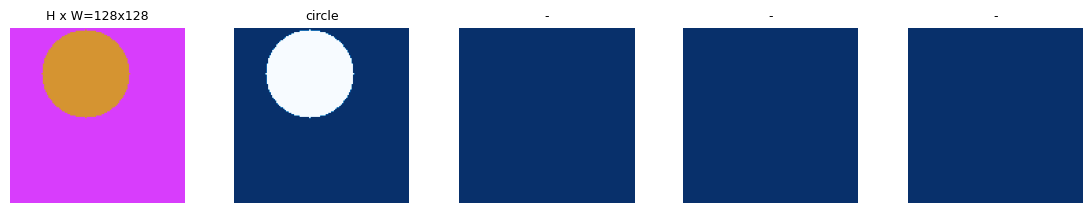

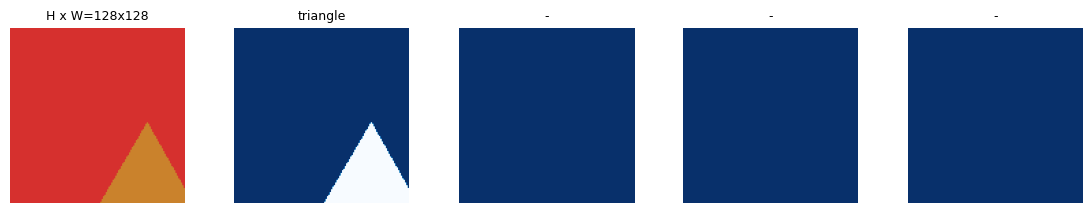

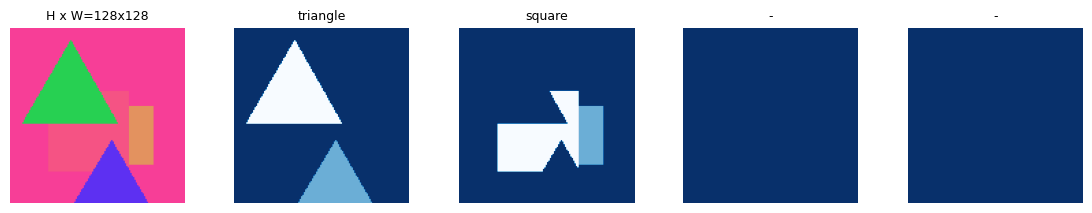

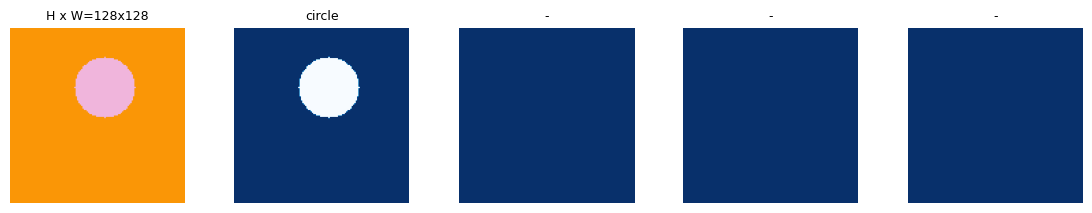

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

----------------------------debug traceback_utils.py 65
The caller function is 'build' in module 'mrcnn.model'
----------------------------debug traceback_utils.py 65
The caller function is 'Input' in module 'keras.engine.input_layer'
----------------------------debug traceback_utils.py 65
The caller function is 'build' in module 'mrcnn.model'
----------------------------debug traceback_utils.py 65
The caller function is 'Input' in module 'keras.engine.input_layer'
----------------------------debug traceback_utils.py 65
The caller function is 'build' in module 'mrcnn.model'
----------------------------debug traceback_utils.py 65
The caller function is 'Input' in module 'keras.engine.input_layer'
----------------------------debug traceback_utils.py 65
The caller function is 'build' in module 'mrcnn.model'
----------------------------debug traceback_utils.py 65
The caller function is 'Input' in module 'keras.engine.input_layer'
----------------------------debug traceback_utils.py 65
The 

The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
----------------------------debug keras_tensor.py 243
The caller function is 'keras_tensor_to_placeholder' in module 'keras.engine.keras_tensor' (currently in keras_tensor.py 248)
keras_tensor.py self: KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), name='zero_padding2d/Pad:0', description="created by layer 'zero_padding2d'")
component_to_placeholder: <function KerasTensor._to_placeholder.<locals>.component_to_placeholder at 0x00000242FCA1CCA0>
self.type_spec: TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (current in keras.engine.keras_tensor 238)
The caller function is 'placeholder' in module 'tensorflow.python.ops.array_ops' (current in gen_array_ops.py 6902)
name: None
dtype: 1
The caller function is '<listcomp>' in module 'tensorflo

----------------------------debug traceback_utils.py 101
The caller function is '_infer_output_signature' in module 'keras.engine.base_layer' (current in base_layer.py 989)
----------------------------debug api.py 321
The caller function is 'wrapper' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_file_1tl_152'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_file_1tl_152'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'conv_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): activation_1
The caller 

----------------------------debug traceback_utils.py 101
The caller function is '_infer_output_signature' in module 'keras.engine.base_layer' (current in base_layer.py 989)
----------------------------debug api.py 321
The caller function is 'wrapper' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_file_1tl_152'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_file_1tl_152'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'conv_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): add
The caller function 

----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'identity_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): bn2b_branch2c
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'res2b_branch2c')>,)
kwargs: {'training': False}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
----

The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
----------------------------debug keras_tensor.py 243
The caller function is 'keras_tensor_to_placeholder' in module 'keras.engine.keras_tensor' (currently in keras_tensor.py 248)
keras_tensor.py self: KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name=None), name='activation_6/Relu:0', description="created by layer 'activation_6'")
component_to_placeholder: <function KerasTensor._to_placeholder.<locals>.component_to_placeholder at 0x00000242FCA1DF30>
self.type_spec: TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name=None)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (current in keras.engine.keras_tensor 238)
The caller function is 'placeholder' in module 'tensorflow.python.ops.array_ops' (current in gen_array_ops.py 6902)
name: None
dtype: 1
The caller function is '<listcomp>' in module 'tensorflow

The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
----------------------------debug base_layer.py 2441
----------------------------debug traceback_utils.py 101
The caller function is '_infer_output_signature' in module 'keras.engine.base_layer' (current in base_layer.py 989)
----------------------------debug api.py 321
The caller function is 'wrapper' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_file_1tl_152'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_file_1tl_152'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug base_

The caller function is '_infer_output_signature' in module 'keras.engine.base_layer' (current in base_layer.py 989)
----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'identity_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): bn3b_branch2a
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'res3b_branch2a')>,)
kwargs: {'training': False}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)

The caller function is 'identity_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): res3b_out
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'add_4')>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
----------------------------debug keras_tensor.py 243
The caller function is 'keras_tensor_to_placeholder' in module 'keras.engine.keras_tensor' (currently in keras_tensor.py 248)
keras_tensor.py 

----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'identity_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): bn3c_branch2c
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'res3c_branch2c')>,)
kwargs: {'training': False}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
----

----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'identity_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): activation_14
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'bn3d_branch2b')>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
----------------------

----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'conv_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): activation_15
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'bn4a_branch2a')>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
--------------------------

The caller function is 'conv_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): res4a_branch1
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'res3d_out')>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
----------------------------debug keras_tensor.py 243
The caller function is 'keras_tensor_to_placeholder' in module 'keras.engine.keras_tensor' (currently in keras_tensor.py 248)
keras_tensor

----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'identity_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): activation_17
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'bn4b_branch2a')>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
----------------------

----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'identity_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): add_8
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: ([<KerasTensor: shape=(None, None, None, 1024) dtype=float32 (created by layer 'bn4b_branch2c')>, <KerasTensor: shape=(None, None, None, 1024) dtype=float32 (created by layer 'res4a_out')>],)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The caller function is '<listcomp>' in module 

----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'identity_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): activation_20
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'bn4c_branch2b')>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
----------------------

----------------------------debug traceback_utils.py 101
The caller function is '_infer_output_signature' in module 'keras.engine.base_layer' (current in base_layer.py 989)
----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'identity_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): bn4d_branch2b
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'res4d_branch2b')>,)
kwargs: {'training': False}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 

The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (current in keras.engine.keras_tensor 238)
The caller function is 'placeholder' in module 'tensorflow.python.ops.array_ops' (current in gen_array_ops.py 6902)
name: None
dtype: 1
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
----------------------------debug base_layer.py 2441
----------------------------debug traceback_utils.py 101
The caller function is '_infer_output_signature' in module 'keras.engine.base_layer' (current in base_layer.py 989)
----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'identity_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): res4e_branch2b
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_lay

----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'identity_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): bn4f_branch2a
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'res4f_branch2a')>,)
kwargs: {'training': False}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
----

The caller function is '_infer_output_signature' in module 'keras.engine.base_layer' (current in base_layer.py 989)
----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'identity_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): res4g_branch2a
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(None, None, None, 1024) dtype=float32 (created by layer 'res4f_out')>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The caller function

----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'identity_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): bn4g_branch2c
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(None, None, None, 1024) dtype=float32 (created by layer 'res4g_branch2c')>,)
kwargs: {'training': False}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
---

----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'identity_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): activation_30
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'bn4h_branch2b')>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
----------------------

----------------------------debug traceback_utils.py 101
The caller function is '_infer_output_signature' in module 'keras.engine.base_layer' (current in base_layer.py 989)
----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'identity_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): bn4i_branch2b
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'res4i_branch2b')>,)
kwargs: {'training': False}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 

----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'identity_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): bn4j_branch2a
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'res4j_branch2a')>,)
kwargs: {'training': False}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
----

----------------------------debug traceback_utils.py 101
The caller function is '_infer_output_signature' in module 'keras.engine.base_layer' (current in base_layer.py 989)
----------------------------debug api.py 321
The caller function is 'wrapper' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_file_1tl_152'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_file_1tl_152'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'identity_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): add_16
The caller fu

----------------------------debug traceback_utils.py 101
The caller function is '_infer_output_signature' in module 'keras.engine.base_layer' (current in base_layer.py 989)
----------------------------debug api.py 321
The caller function is 'wrapper' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_file_1tl_152'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_file_1tl_152'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'identity_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): activation_36
The ca

The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
----------------------------debug keras_tensor.py 243
The caller function is 'keras_tensor_to_placeholder' in module 'keras.engine.keras_tensor' (currently in keras_tensor.py 248)
keras_tensor.py self: KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 256), dtype=tf.float32, name=None), name='res4l_branch2a/BiasAdd:0', description="created by layer 'res4l_branch2a'")
component_to_placeholder: <function KerasTensor._to_placeholder.<locals>.component_to_placeholder at 0x00000242FCA1F490>
self.type_spec: TensorSpec(shape=(None, None, None, 256), dtype=tf.float32, name=None)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (current in keras.engine.keras_tensor 238)
The caller function is 'placeholder' in module 'tensorflow.py

----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'identity_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): add_18
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: ([<KerasTensor: shape=(None, None, None, 1024) dtype=float32 (created by layer 'bn4l_branch2c')>, <KerasTensor: shape=(None, None, None, 1024) dtype=float32 (created by layer 'res4k_out')>],)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The caller function is '<listcomp>' in module

----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'identity_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): bn4m_branch2c
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(None, None, None, 1024) dtype=float32 (created by layer 'res4m_branch2c')>,)
kwargs: {'training': False}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
---

The caller function is 'identity_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): activation_42
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'bn4n_branch2b')>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
----------------------------debug keras_tensor.py 243
The caller function is 'keras_tensor_to_placeholder' in module 'keras.engine.keras_tensor' (currently in keras_tensor.py 248)
kera

The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
----------------------------debug base_layer.py 2441
----------------------------debug traceback_utils.py 101
The caller function is '_infer_output_signature' in module 'keras.engine.base_layer' (current in base_layer.py 989)
----------------------------debug api.py 321
The caller function is 'wrapper' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_file_1tl_152'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_file_1tl_152'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug base_

The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
----------------------------debug base_layer.py 2441
----------------------------debug traceback_utils.py 101
The caller function is '_infer_output_signature' in module 'keras.engine.base_layer' (current in base_layer.py 989)
----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'identity_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): bn4p_branch2b
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'res4p_branch2b')>,)
kwargs: {'training': False}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
-------

The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
----------------------------debug keras_tensor.py 243
The caller function is 'keras_tensor_to_placeholder' in module 'keras.engine.keras_tensor' (currently in keras_tensor.py 248)
keras_tensor.py self: KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 256), dtype=tf.float32, name=None), name='res4q_branch2a/BiasAdd:0', description="created by layer 'res4q_branch2a'")
component_to_placeholder: <function KerasTensor._to_placeholder.<locals>.component_to_placeholder at 0x00000242FCA1F400>
self.type_spec: TensorSpec(shape=(None, None, None, 256), dtype=tf.float32, name=None)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (current in keras.engine.keras_tensor 238)
The caller function is 'placeholder' in module 'tensorflow.python.ops.array_ops' (current in gen_array_ops.py 6902)
name: None
dtype: 1
The caller function is '<listcomp>' in module 't

----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'identity_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): res4r_branch2a
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(None, None, None, 1024) dtype=float32 (created by layer 'res4q_out')>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
------------------------

----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'identity_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): add_24
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: ([<KerasTensor: shape=(None, None, None, 1024) dtype=float32 (created by layer 'bn4r_branch2c')>, <KerasTensor: shape=(None, None, None, 1024) dtype=float32 (created by layer 'res4q_out')>],)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The caller function is '<listcomp>' in module

The caller function is 'identity_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): bn4s_branch2c
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(None, None, None, 1024) dtype=float32 (created by layer 'res4s_branch2c')>,)
kwargs: {'training': False}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
----------------------------debug keras_tensor.py 243
The caller function is 'keras_tensor_to_placeholder' in module 'keras.engine.keras_tensor' (currently in keras_

The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
----------------------------debug keras_tensor.py 243
The caller function is 'keras_tensor_to_placeholder' in module 'keras.engine.keras_tensor' (currently in keras_tensor.py 248)
keras_tensor.py self: KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 256), dtype=tf.float32, name=None), name='activation_54/Relu:0', description="created by layer 'activation_54'")
component_to_placeholder: <function KerasTensor._to_placeholder.<locals>.component_to_placeholder at 0x00000242FCA1F760>
self.type_spec: TensorSpec(shape=(None, None, None, 256), dtype=tf.float32, name=None)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (current in keras.engine.keras_tensor 238)
The caller function is 'placeholder' in module 'tensorflow.python.

----------------------------debug traceback_utils.py 101
The caller function is '_infer_output_signature' in module 'keras.engine.base_layer' (current in base_layer.py 989)
----------------------------debug api.py 321
The caller function is 'wrapper' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_file_1tl_152'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_file_1tl_152'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'identity_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): activation_56
The ca

----------------------------debug traceback_utils.py 101
The caller function is '_infer_output_signature' in module 'keras.engine.base_layer' (current in base_layer.py 989)
----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'identity_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): bn4v_branch2b
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'res4v_branch2b')>,)
kwargs: {'training': False}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 

----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'identity_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): activation_59
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'bn4w_branch2a')>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
----------------------

----------------------------debug traceback_utils.py 101
The caller function is '_infer_output_signature' in module 'keras.engine.base_layer' (current in base_layer.py 989)
----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'conv_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): bn5a_branch2a
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'res5a_branch2a')>,)
kwargs: {'training': False}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'ker

----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'conv_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): bn5a_branch2c
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(None, None, None, 2048) dtype=float32 (created by layer 'res5a_branch2c')>,)
kwargs: {'training': False}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
-------

----------------------------debug traceback_utils.py 101
The caller function is '_infer_output_signature' in module 'keras.engine.base_layer' (current in base_layer.py 989)
----------------------------debug api.py 321
The caller function is 'wrapper' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_file_1tl_152'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_file_1tl_152'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'identity_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): activation_63
The ca

----------------------------debug traceback_utils.py 101
The caller function is '_infer_output_signature' in module 'keras.engine.base_layer' (current in base_layer.py 989)
----------------------------debug api.py 321
The caller function is 'wrapper' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_file_1tl_152'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_file_1tl_152'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'identity_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): add_31
The caller fu

----------------------------debug traceback_utils.py 101
The caller function is '_infer_output_signature' in module 'keras.engine.base_layer' (current in base_layer.py 989)
----------------------------debug api.py 321
The caller function is 'wrapper' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_file_1tl_152'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_file_1tl_152'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'identity_block' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): activation_66
The ca

The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
----------------------------debug keras_tensor.py 243
The caller function is 'keras_tensor_to_placeholder' in module 'keras.engine.keras_tensor' (currently in keras_tensor.py 248)
keras_tensor.py self: KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 1024), dtype=tf.float32, name=None), name='res4w_out/Relu:0', description="created by layer 'res4w_out'")
component_to_placeholder: <function KerasTensor._to_placeholder.<locals>.component_to_placeholder at 0x0000024286020D30>
self.type_spec: TensorSpec(shape=(None, None, None, 1024), dtype=tf.float32, name=None)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (current in keras.engine.keras_tensor 238)
The caller function is 'placeholder' in module 'tensorflow.python.ops.array_ops' (current in gen_array_ops.py 6902)
name: None
dtype: 1
The caller function is '<listcomp>' in module 'tensorflow.p

----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'build' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): fpn_p3
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'fpn_p3add')>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
----------------------------debug keras_te

----------------------------debug traceback_utils.py 101
The caller function is '_infer_output_signature' in module 'keras.engine.base_layer' (current in base_layer.py 989)
----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'rpn_graph' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): lambda_1
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(None, None, None, 6) dtype=float32 (created by layer 'rpn_class_raw')>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (cur

outputs: Tensor("rpn_model/lambda_2/Reshape:0", shape=(None, None, 4), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): rpn_class_xxx
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'rpn_model/lambda_1/Reshape:0' shape=(None, None, 2) dtype=float32>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("rpn_model/lambda_1/Reshape:0", shape=(None, None, 2), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller function is '__call__' in module 'keras.engine.base_layer' (current 

outputs: Tensor("rpn_model/rpn_bbox_pred/BiasAdd:0", shape=(None, None, None, 12), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): lambda_1
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'rpn_model/rpn_class_raw/BiasAdd:0' shape=(None, None, None, 6) dtype=float32>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("rpn_model/rpn_class_raw/BiasAdd:0", shape=(None, None, None, 6), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller function is '__call__' in module 'keras

----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_filenf7czxqj'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_filenf7czxqj'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_filenf7czxqj'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_filenf7czxqj'
----------------------------debug api.py 451
The caller function is 'converted_call' in module

----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_file27dbl98h'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is '<lambda>' in module '__autograph_generated_filenf7czxqj'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_file27dbl98h'
----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_file27dbl98h'
----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_file27dbl98h'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'te

----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_file27dbl98h'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is '<lambda>' in module '__autograph_generated_filenf7czxqj'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_file27dbl98h'
----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_file27dbl98h'
----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_file27dbl98h'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'te

----------------------------debug api.py 321
The caller function is 'tf__apply_box_deltas_graph' in module '__autograph_generated_filescfv4h7d'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__apply_box_deltas_graph' in module '__autograph_generated_filescfv4h7d'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__apply_box_deltas_graph' in module '__autograph_generated_filescfv4h7d'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_file27dbl98h'
----------------------------debug api.p

----------------------------debug api.py 321
The caller function is 'tf__clip_boxes_graph' in module '__autograph_generated_filemez4pns9'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__clip_boxes_graph' in module '__autograph_generated_filemez4pns9'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__clip_boxes_graph' in module '__autograph_generated_filemez4pns9'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__clip_boxes_graph' in module '__autograph_generated_filemez4pns9'
----------------------------debug api.py 451
T

----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_file27dbl98h'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'nms' in module '__autograph_generated_filenf7czxqj'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'nms' in module '__autograph_generated_filenf7czxqj'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'nms' in module '__autograph_generated_filenf7czxqj'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.p

----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_file3svg53le'
----------------------------debug api.py 321
The caller function is 'tf__batch_slice' in module '__autograph_generated_file27dbl98h'
----------------------------debug api.py 321
The caller function is 'tf__batch_slice' in module '__autograph_generated_file27dbl98h'
----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_file27dbl98h'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is '<lambda>' in module '__autograph_generated_file3svg53le'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'convert

----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The calle

The caller function is '<lambda>' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
The caller function is 'placeholder' in module 'tensorflow.python.ops.array_ops' (current in gen_array_ops.py 6902)
name: None
dtype: 1
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_

----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 321
The caller function is 'tf__trim_zeros_graph' in module '__autograph_generated_fileo_ypqu77'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__trim_zeros_graph' in module '__autograph_generated_fileo_ypqu77'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__trim_zeros_graph' in module '__autograph_generated_fileo_ypqu77'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.p

----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
------------------

----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug func_graph.py 1187
The caller function is 'cond_v2' in module 'tensorflow.python.ops.cond_v2'
----------------------------debug func_graph.py 1187
The caller function is 'cond_v2' in module 'tensorflow.python.ops.cond_v2'
The caller function is 'placeholder' in module 'tensorflow.python.ops.array_ops' (current in gen_array_ops.py 6902)
name: None
dtype: 1
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The c

----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The calle

----------------------------debug api.py 321
The caller function is 'tf__box_refinement_graph' in module '__autograph_generated_filemg743xpe'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__box_refinement_graph' in module '__autograph_generated_filemg743xpe'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__box_refinement_graph' in module '__autograph_generated_filemg743xpe'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
---------------------------

----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
------------------

----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451


----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_file27dbl98h'
----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_file27dbl98h'
----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_file27dbl98h'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is '<lambda>' in module '__autograph_generated_file3svg53le'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detecti

----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The calle

The caller function is 'tf__box_refinement_graph' in module '__autograph_generated_filemg743xpe'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__box_refinement_graph' in module '__autograph_generated_filemg743xpe'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__box_refinement_graph' in module '__autograph_generated_filemg743xpe'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__box_refinement_graph' in module '__autograph_generated_filemg743xpe'
----------------------------debug api.py 451
The caller function is 'conver

----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
------------------

----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
------------------

----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_file27dbl98h'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is '<lambda>' in module '__autograph_generated_file3svg53le'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller

----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The calle

The caller function is 'placeholder' in module 'tensorflow.python.ops.array_ops' (current in gen_array_ops.py 6902)
name: None
dtype: 1
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 321
The caller function is 'tf__box_refinement_graph' in module '__autograph_generated_filemg743xpe'
-------------------

----------------------------debug api.py 321
The caller function is 'tf__trim_zeros_graph' in module '__autograph_generated_fileo_ypqu77'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
-------------------------

----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
------------------

The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
----------------------------debug base_layer.py 2441
----------------------------debug traceback_utils.py 101
The caller function is '_infer_output_signature' in module 'keras.engine.base_layer' (current in base_layer.py 989)
----------------------------debug api.py 321
The caller function is 'wrapper' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_fileqy5gz0pe'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_fileqy5gz0pe'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_fileqy5gz0pe'
------------------------

----------------------------debug traceback_utils.py 101
The caller function is '_infer_output_signature' in module 'keras.engine.base_layer' (current in base_layer.py 989)
----------------------------debug traceback_utils.py 65
The caller function is 'call' in module 'keras.layers.rnn.time_distributed'
----------------------------debug base_layer.py 983
str(self.name): conv2d
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mrcnn_class_conv1/Reshape:0' shape=(None, 7, 7, 256) dtype=float32>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mrcnn_class_conv1/Reshape:0", shape=(None, 7, 7, 256), dtype=float32)
----------------------------debug traceback_utils.py 101
Th

----------------------------debug traceback_utils.py 101
The caller function is '_infer_output_signature' in module 'keras.engine.base_layer' (current in base_layer.py 989)
----------------------------debug traceback_utils.py 65
The caller function is 'call' in module 'keras.layers.rnn.time_distributed'
----------------------------debug base_layer.py 983
str(self.name): batch_norm_1
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mrcnn_class_bn2/Reshape:0' shape=(None, 1, 1, 1024) dtype=float32>,)
kwargs: {'training': False}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mrcnn_class_bn2/Reshape:0", shape=(None, 1, 1, 1024), dtype=float32)
----------------------------debug trac

----------------------------debug traceback_utils.py 65
The caller function is 'call' in module 'keras.layers.rnn.time_distributed'
----------------------------debug base_layer.py 983
str(self.name): dense_1
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mrcnn_bbox_fc/Reshape:0' shape=(None, 1024) dtype=float32>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mrcnn_bbox_fc/Reshape:0", shape=(None, 1024), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller function is '__call__' in module 'keras.engine.base_layer' (current in base_layer.py 989)
outputs: Tensor("mrcnn_bbox_fc/dense_1/BiasAdd:0", shape=(None, 16), dtype=float32)
-------

----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_fileqy5gz0pe'
----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_fileqy5gz0pe'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_fileqy5gz0pe'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_fileqy5gz0pe'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'loop_body' in module 

The caller function is 'build_fpn_mask_graph' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): mrcnn_mask_conv1
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(8, None, 14, 14, 256) dtype=float32 (created by layer 'roi_align_mask')>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
----------------------------debug keras_tensor.py 243
The caller function is 'keras_tensor_to_placeholder' in module 'keras.engine.keras_tensor' (currently in keras_tensor.py 

----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'build_fpn_mask_graph' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): mrcnn_mask_bn2
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(8, None, 14, 14, 256) dtype=float32 (created by layer 'mrcnn_mask_conv2')>,)
kwargs: {'training': False}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 6

The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
----------------------------debug base_layer.py 2441
----------------------------debug traceback_utils.py 101
The caller function is '_infer_output_signature' in module 'keras.engine.base_layer' (current in base_layer.py 989)
----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'build_fpn_mask_graph' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): mrcnn_mask_conv4
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(8, None, 14, 14, 256) dtype=float32 (created by layer 'activation_72')>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
-----------------

outputs: Tensor("mrcnn_mask_deconv/conv2d_transpose/Relu:0", shape=(None, 28, 28, 256), dtype=float32)
----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'build_fpn_mask_graph' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): mrcnn_mask
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(8, None, 28, 28, 256) dtype=float32 (created by layer 'mrcnn_mask_deconv')>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The caller function is '

----------------------------debug func_graph.py 1187
The caller function is 'cond_v2' in module 'tensorflow.python.ops.cond_v2'
----------------------------debug func_graph.py 1187
The caller function is 'cond_v2' in module 'tensorflow.python.ops.cond_v2'
The caller function is 'placeholder' in module 'tensorflow.python.ops.array_ops' (current in gen_array_ops.py 6902)
name: None
dtype: 1
The caller function is 'placeholder' in module 'tensorflow.python.ops.array_ops' (current in gen_array_ops.py 6902)
name: None
dtype: 1
----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'build' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): mrcnn_class_loss
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: ([<KerasTensor: shape=(8, None) dtype=int32 (created b

----------------------------debug func_graph.py 1187
The caller function is 'cond_v2' in module 'tensorflow.python.ops.cond_v2'
----------------------------debug func_graph.py 1187
The caller function is 'cond_v2' in module 'tensorflow.python.ops.cond_v2'
The caller function is 'placeholder' in module 'tensorflow.python.ops.array_ops' (current in gen_array_ops.py 6902)
name: None
dtype: 1
The caller function is 'placeholder' in module 'tensorflow.python.ops.array_ops' (current in gen_array_ops.py 6902)
name: None
dtype: 1
----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is 'build' in module 'mrcnn.model'
----------------------------debug base_layer.py 983
str(self.name): mrcnn_mask_loss
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: ([<KerasTensor: shape=(8, None, 28, 28) dtype=float32 (

----------------------------debug functional.py 1102
inputs: [<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_image')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'input_image_meta')>, <KerasTensor: shape=(None, None, 1) dtype=int32 (created by layer 'input_rpn_match')>, <KerasTensor: shape=(None, None, 4) dtype=float32 (created by layer 'input_rpn_bbox')>, <KerasTensor: shape=(None, None) dtype=int32 (created by layer 'input_gt_class_ids')>, <KerasTensor: shape=(None, None, 4) dtype=float32 (created by layer 'input_gt_boxes')>, <KerasTensor: shape=(None, 56, 56, None) dtype=bool (created by layer 'input_gt_masks')>]
The caller function is '_init_graph_network' in module 'keras.engine.functional' (current in functional.py 1108)
----------------------------debug functional.py 1159
len nodes_by_depth: 364
layers_with_complete_input: ['zero_padding2d', 'conv1', 'bn_conv1', 'activation', 'max_pooling2d', 'res2a_branch2a', 'bn2a_branch2a'

In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [9]:
import warnings
warnings.filterwarnings('ignore')
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layerh ks to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')

----------------------------debug model.py 2441
----------------------------debug model.py 2470

Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\zhhua\OneDrive\Desktop\PythonProgram\CAT\logs\shapes20230819T0824\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4    

reg_losses: [<tf.Tensor: shape=(), dtype=float32, numpy=6.3534964e-09>, <tf.Tensor: shape=(), dtype=float32, numpy=2.8046672e-09>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0142325e-08>, <tf.Tensor: shape=(), dtype=float32, numpy=2.2885671e-10>, <tf.Tensor: shape=(), dtype=float32, numpy=5.756018e-09>, <tf.Tensor: shape=(), dtype=float32, numpy=4.1422335e-10>, <tf.Tensor: shape=(), dtype=float32, numpy=4.0682755e-09>, <tf.Tensor: shape=(), dtype=float32, numpy=4.5369797e-10>, <tf.Tensor: shape=(), dtype=float32, numpy=3.514149e-09>, <tf.Tensor: shape=(), dtype=float32, numpy=1.4325523e-09>, <tf.Tensor: shape=(), dtype=float32, numpy=2.982413e-09>, <tf.Tensor: shape=(), dtype=float32, numpy=5.347553e-10>, <tf.Tensor: shape=(), dtype=float32, numpy=2.329253e-09>, <tf.Tensor: shape=(), dtype=float32, numpy=2.3652863e-10>, <tf.Tensor: shape=(), dtype=float32, numpy=2.5858478e-09>, <tf.Tensor: shape=(), dtype=float32, numpy=2.8162112e-10>, <tf.Tensor: shape=(), dtype=float32, numpy=7.022

train_generator_i_j: [array([[[[  85.3,   75.2,  -72.9],
         [  85.3,   75.2,  -72.9],
         [  85.3,   75.2,  -72.9],
         ...,
         [  85.3,   75.2,  -72.9],
         [  85.3,   75.2,  -72.9],
         [  85.3,   75.2,  -72.9]],

        [[  85.3,   75.2,  -72.9],
         [  85.3,   75.2,  -72.9],
         [  85.3,   75.2,  -72.9],
         ...,
         [  85.3,   75.2,  -72.9],
         [  85.3,   75.2,  -72.9],
         [  85.3,   75.2,  -72.9]],

        [[  85.3,   75.2,  -72.9],
         [  85.3,   75.2,  -72.9],
         [  85.3,   75.2,  -72.9],
         ...,
         [  85.3,   75.2,  -72.9],
         [  85.3,   75.2,  -72.9],
         [  85.3,   75.2,  -72.9]],

        ...,

        [[  85.3,   75.2,  -72.9],
         [  85.3,   75.2,  -72.9],
         [  85.3,   75.2,  -72.9],
         ...,
         [  85.3,   75.2,  -72.9],
         [  85.3,   75.2,  -72.9],
         [  85.3,   75.2,  -72.9]],

        [[  85.3,   75.2,  -72.9],
         [  85.3,   75.2,

----------------------------debug function.py 2718
The caller function is '_get_concrete_function_garbage_collected' in module 'tensorflow.python.eager.function'
----------------------------debug function.py 2654
The caller function is '_maybe_define_function' in module 'tensorflow.python.eager.function'
----------------------------debug func_graph.py 1187
The caller function is '_create_graph_function' in module 'tensorflow.python.eager.function'
----------------------------debug api.py 321
The caller function is 'wrapper' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug function.py 2718
The caller function is '_get_concrete_function_garbage_collected' in module 'tensorflow.python.eager.function'
----------------------------debug function.py 2654
The caller function is '_maybe_define_function' in module 'tensorflow.pyth

outputs: Tensor("mask_rcnn/res2a_branch2a/BiasAdd:0", shape=(None, None, None, 64), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): bn2a_branch2a
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/res2a_branch2a/BiasAdd:0' shape=(None, None, None, 64) dtype=float32>,)
kwargs: {'training': False}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/res2a_branch2a/BiasAdd:0", shape=(None, None, None, 64), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller function is 

The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/res2a_branch1/BiasAdd:0' shape=(None, None, None, 256) dtype=float32>,)
kwargs: {'training': False}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/res2a_branch1/BiasAdd:0", shape=(None, None, None, 256), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller function is '__call__' in module 'keras.engine.base_layer' (current in base_layer.py 989)
----------------------------debug api.py 321
The caller function is 'wrapper' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_f

outputs: Tensor("mask_rcnn/bn2b_branch2b/FusedBatchNormV3:0", shape=(None, None, None, 64), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): activation_4
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/bn2b_branch2b/FusedBatchNormV3:0' shape=(None, None, None, 64) dtype=float32>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/bn2b_branch2b/FusedBatchNormV3:0", shape=(None, None, None, 64), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller functi

outputs: Tensor("mask_rcnn/bn2c_branch2a/FusedBatchNormV3:0", shape=(None, None, None, 64), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): activation_5
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/bn2c_branch2a/FusedBatchNormV3:0' shape=(None, None, None, 64) dtype=float32>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/bn2c_branch2a/FusedBatchNormV3:0", shape=(None, None, None, 64), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller functi

outputs: Tensor("mask_rcnn/bn3a_branch2a/FusedBatchNormV3:0", shape=(None, None, None, 128), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): activation_7
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/bn3a_branch2a/FusedBatchNormV3:0' shape=(None, None, None, 128) dtype=float32>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/bn3a_branch2a/FusedBatchNormV3:0", shape=(None, None, None, 128), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller fun

outputs: Tensor("mask_rcnn/bn3a_branch2c/FusedBatchNormV3:0", shape=(None, None, None, 512), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): bn3a_branch1
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/res3a_branch1/BiasAdd:0' shape=(None, None, None, 512) dtype=float32>,)
kwargs: {'training': False}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/res3a_branch1/BiasAdd:0", shape=(None, None, None, 512), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller func

The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): bn3b_branch2c
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/res3b_branch2c/BiasAdd:0' shape=(None, None, None, 512) dtype=float32>,)
kwargs: {'training': False}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/res3b_branch2c/BiasAdd:0", shape=(None, None, None, 512), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller function is '__call__' in module 'keras.engine.base_layer' (current in base_layer.py 989)
----------------------------debug api.py 321
The caller function is 'wrappe

outputs: Tensor("mask_rcnn/res3c_branch2b/BiasAdd:0", shape=(None, None, None, 128), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): bn3c_branch2b
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/res3c_branch2b/BiasAdd:0' shape=(None, None, None, 128) dtype=float32>,)
kwargs: {'training': False}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/res3c_branch2b/BiasAdd:0", shape=(None, None, None, 128), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller function 

The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
outputs: Tensor("mask_rcnn/bn3d_branch2b/FusedBatchNormV3:0", shape=(None, None, None, 128), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): activation_14
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/bn3d_branch2b/FusedBatchNormV3:0' shape=(None, None, None, 128) dtype=float32>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/bn3d_branch2b/FusedBatchNormV3:0", shape=(None, None, None, 12

The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): bn4a_branch1
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/res4a_branch1/BiasAdd:0' shape=(None, None, None, 1024) dtype=float32>,)
kwargs: {'training': False}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/res4a_branch1/BiasAdd:0", shape=(None, None, None, 1024), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller function is '__call__' in module 'keras.engine.base_layer' (current in base_layer.py 989)
----------------------------debug api.py 321
The caller function is 'wrapper

outputs: Tensor("mask_rcnn/res4b_branch2b/BiasAdd:0", shape=(None, None, None, 256), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): bn4b_branch2b
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/res4b_branch2b/BiasAdd:0' shape=(None, None, None, 256) dtype=float32>,)
kwargs: {'training': False}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/res4b_branch2b/BiasAdd:0", shape=(None, None, None, 256), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller function 

outputs: Tensor("mask_rcnn/bn4c_branch2a/FusedBatchNormV3:0", shape=(None, None, None, 256), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): activation_19
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/bn4c_branch2a/FusedBatchNormV3:0' shape=(None, None, None, 256) dtype=float32>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/bn4c_branch2a/FusedBatchNormV3:0", shape=(None, None, None, 256), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller fu

outputs: Tensor("mask_rcnn/add_9/add:0", shape=(None, None, None, 1024), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): res4c_out
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/add_9/add:0' shape=(None, None, None, 1024) dtype=float32>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/add_9/add:0", shape=(None, None, None, 1024), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller function is '__call__' in module 'keras.engine.base_layer' (curren

The caller function is '__call__' in module 'keras.engine.base_layer' (current in base_layer.py 989)
outputs: Tensor("mask_rcnn/add_10/add:0", shape=(None, None, None, 1024), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): res4d_out
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/add_10/add:0' shape=(None, None, None, 1024) dtype=float32>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/add_10/add:0", shape=(None, None, None, 1024), dtype=float32)
----------------------------de

outputs: Tensor("mask_rcnn/bn4f_branch2b/FusedBatchNormV3:0", shape=(None, None, None, 256), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): activation_26
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/bn4f_branch2b/FusedBatchNormV3:0' shape=(None, None, None, 256) dtype=float32>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/bn4f_branch2b/FusedBatchNormV3:0", shape=(None, None, None, 256), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller fu

outputs: Tensor("mask_rcnn/res4g_branch2b/BiasAdd:0", shape=(None, None, None, 256), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): bn4g_branch2b
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/res4g_branch2b/BiasAdd:0' shape=(None, None, None, 256) dtype=float32>,)
kwargs: {'training': False}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/res4g_branch2b/BiasAdd:0", shape=(None, None, None, 256), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller function 

outputs: Tensor("mask_rcnn/activation_29/Relu:0", shape=(None, None, None, 256), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): res4h_branch2b
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/activation_29/Relu:0' shape=(None, None, None, 256) dtype=float32>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/activation_29/Relu:0", shape=(None, None, None, 256), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller function is '__call__' in module 'ker

outputs: Tensor("mask_rcnn/res4i_branch2a/BiasAdd:0", shape=(None, None, None, 256), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): bn4i_branch2a
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/res4i_branch2a/BiasAdd:0' shape=(None, None, None, 256) dtype=float32>,)
kwargs: {'training': False}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/res4i_branch2a/BiasAdd:0", shape=(None, None, None, 256), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller function 

outputs: Tensor("mask_rcnn/add_15/add:0", shape=(None, None, None, 1024), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): res4i_out
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/add_15/add:0' shape=(None, None, None, 1024) dtype=float32>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/add_15/add:0", shape=(None, None, None, 1024), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller function is '__call__' in module 'keras.engine.base_layer' (cur

outputs: Tensor("mask_rcnn/bn4j_branch2c/FusedBatchNormV3:0", shape=(None, None, None, 1024), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): add_16
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: ([<tf.Tensor 'mask_rcnn/bn4j_branch2c/FusedBatchNormV3:0' shape=(None, None, None, 1024) dtype=float32>, <tf.Tensor 'mask_rcnn/res4i_out/Relu:0' shape=(None, None, None, 1024) dtype=float32>],)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: [<tf.Tensor 'mask_rcnn/bn4j_branch2c/FusedBatchNormV3:0' shape=(None, None, None, 102

outputs: Tensor("mask_rcnn/res4k_branch2c/BiasAdd:0", shape=(None, None, None, 1024), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): bn4k_branch2c
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/res4k_branch2c/BiasAdd:0' shape=(None, None, None, 1024) dtype=float32>,)
kwargs: {'training': False}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/res4k_branch2c/BiasAdd:0", shape=(None, None, None, 1024), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller functi

The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): activation_38
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/bn4l_branch2b/FusedBatchNormV3:0' shape=(None, None, None, 256) dtype=float32>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/bn4l_branch2b/FusedBatchNormV3:0", shape=(None, None, None, 256), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller function is '__call__' in module 'keras.engine.base_layer' (current in base_layer.py 989)
outputs: Tensor("mask_rcnn/activation_38/Relu:0", shape=(None, None, None, 2

outputs: Tensor("mask_rcnn/res4m_branch2b/BiasAdd:0", shape=(None, None, None, 256), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): bn4m_branch2b
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/res4m_branch2b/BiasAdd:0' shape=(None, None, None, 256) dtype=float32>,)
kwargs: {'training': False}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/res4m_branch2b/BiasAdd:0", shape=(None, None, None, 256), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller function 

outputs: Tensor("mask_rcnn/activation_41/Relu:0", shape=(None, None, None, 256), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): res4n_branch2b
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/activation_41/Relu:0' shape=(None, None, None, 256) dtype=float32>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/activation_41/Relu:0", shape=(None, None, None, 256), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller function is '__call__' in module 'ker

outputs: Tensor("mask_rcnn/res4p_branch2a/BiasAdd:0", shape=(None, None, None, 256), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): bn4p_branch2a
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/res4p_branch2a/BiasAdd:0' shape=(None, None, None, 256) dtype=float32>,)
kwargs: {'training': False}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/res4p_branch2a/BiasAdd:0", shape=(None, None, None, 256), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller function 

outputs: Tensor("mask_rcnn/bn4q_branch2c/FusedBatchNormV3:0", shape=(None, None, None, 1024), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): add_23
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: ([<tf.Tensor 'mask_rcnn/bn4q_branch2c/FusedBatchNormV3:0' shape=(None, None, None, 1024) dtype=float32>, <tf.Tensor 'mask_rcnn/res4p_out/Relu:0' shape=(None, None, None, 1024) dtype=float32>],)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: [<tf.Tensor 'mask_rcnn/bn4q_branch2c/FusedBatchNormV3:0' shape=(None, None, None, 102

outputs: Tensor("mask_rcnn/bn4s_branch2b/FusedBatchNormV3:0", shape=(None, None, None, 256), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): activation_52
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/bn4s_branch2b/FusedBatchNormV3:0' shape=(None, None, None, 256) dtype=float32>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/bn4s_branch2b/FusedBatchNormV3:0", shape=(None, None, None, 256), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller fu

outputs: Tensor("mask_rcnn/bn4t_branch2a/FusedBatchNormV3:0", shape=(None, None, None, 256), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): activation_53
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/bn4t_branch2a/FusedBatchNormV3:0' shape=(None, None, None, 256) dtype=float32>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/bn4t_branch2a/FusedBatchNormV3:0", shape=(None, None, None, 256), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller fu

outputs: Tensor("mask_rcnn/bn4u_branch2a/FusedBatchNormV3:0", shape=(None, None, None, 256), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): activation_55
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/bn4u_branch2a/FusedBatchNormV3:0' shape=(None, None, None, 256) dtype=float32>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/bn4u_branch2a/FusedBatchNormV3:0", shape=(None, None, None, 256), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller fu

outputs: Tensor("mask_rcnn/bn4v_branch2c/FusedBatchNormV3:0", shape=(None, None, None, 1024), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): add_28
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: ([<tf.Tensor 'mask_rcnn/bn4v_branch2c/FusedBatchNormV3:0' shape=(None, None, None, 1024) dtype=float32>, <tf.Tensor 'mask_rcnn/res4u_out/Relu:0' shape=(None, None, None, 1024) dtype=float32>],)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: [<tf.Tensor 'mask_rcnn/bn4v_branch2c/FusedBatchNormV3:0' shape=(None, None, None, 102

----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_file_1tl_152'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_file_1tl_152'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
outputs: Tensor("mask_rcnn/bn4w_branch2c/FusedBatchNormV3:0", shape=(None, None, None, 1024), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): add_29
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: ([<tf.Tensor 'mask_rcnn/bn4w_branch2c/FusedBatchNormV3:0' shape=(None, None, None, 1024) dtype=float32>, <tf.Tensor 'mask_rcnn/res4v_out/Relu:0' shape=(None, None, None, 1024) d

outputs: Tensor("mask_rcnn/bn5a_branch2b/FusedBatchNormV3:0", shape=(None, None, None, 512), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): activation_62
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/bn5a_branch2b/FusedBatchNormV3:0' shape=(None, None, None, 512) dtype=float32>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/bn5a_branch2b/FusedBatchNormV3:0", shape=(None, None, None, 512), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller fu

outputs: Tensor("mask_rcnn/bn5b_branch2a/FusedBatchNormV3:0", shape=(None, None, None, 512), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): activation_63
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/bn5b_branch2a/FusedBatchNormV3:0' shape=(None, None, None, 512) dtype=float32>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/bn5b_branch2a/FusedBatchNormV3:0", shape=(None, None, None, 512), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller fu

outputs: Tensor("mask_rcnn/res5c_branch2a/BiasAdd:0", shape=(None, None, None, 512), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): bn5c_branch2a
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/res5c_branch2a/BiasAdd:0' shape=(None, None, None, 512) dtype=float32>,)
kwargs: {'training': False}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/res5c_branch2a/BiasAdd:0", shape=(None, None, None, 512), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller function 

The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): res5c_out
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/add_32/add:0' shape=(None, None, None, 2048) dtype=float32>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/add_32/add:0", shape=(None, None, None, 2048), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller function is '__call__' in module 'keras.engine.base_layer' (current in base_layer.py 989)
outputs: Tensor("mask_rcnn/res5c_out/Relu:0", shape=(None, None, None, 2048), dtype=float32)
-------------------------

The caller function is '__call__' in module 'keras.engine.base_layer' (current in base_layer.py 989)
outputs: Tensor("mask_rcnn/fpn_p3add/add:0", shape=(None, None, None, 256), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): fpn_p3upsampled
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/fpn_p3add/add:0' shape=(None, None, None, 256) dtype=float32>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/fpn_p3add/add:0", shape=(None, None, None, 256), dtype=float32)
------------------

outputs: Tensor("mask_rcnn/rpn_model/rpn_class_raw/BiasAdd:0", shape=(None, None, None, 6), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): rpn_bbox_pred
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/rpn_model/rpn_conv_shared/Relu:0' shape=(None, None, None, 512) dtype=float32>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/rpn_model/rpn_conv_shared/Relu:0", shape=(None, None, None, 512), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller fun

outputs: Tensor("mask_rcnn/rpn_model/lambda_1/Reshape_2:0", shape=(None, None, 2), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): lambda_2
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/rpn_model/rpn_bbox_pred/BiasAdd_2:0' shape=(None, None, None, 12) dtype=float32>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/rpn_model/rpn_bbox_pred/BiasAdd_2:0", shape=(None, None, None, 12), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller function is '

outputs: Tensor("mask_rcnn/rpn_model/lambda_2/Reshape_3:0", shape=(None, None, 4), dtype=float32)
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): rpn_class_xxx
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<tf.Tensor 'mask_rcnn/rpn_model/lambda_1/Reshape_3:0' shape=(None, None, 2) dtype=float32>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: Tensor("mask_rcnn/rpn_model/lambda_1/Reshape_3:0", shape=(None, None, 2), dtype=float32)
----------------------------debug traceback_utils.py 101
The caller function is '__call__' in module

----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_filenf7czxqj'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_filenf7czxqj'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_filenf7czxqj'
----------------------------debug api.py 321
The caller function is 'tf__batch_slice' in module '__autograph_generated_file27dbl98h'
----------------------------debug api.py 321
The caller function is 'tf__batch_slice' in module '__autograph_generated_file27dbl98h'
----------------------------debug api.py 321
The caller function is 'loop_body' in modul

----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_file27dbl98h'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is '<lambda>' in module '__autograph_generated_filenf7czxqj'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_file27dbl98h'
----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_file27dbl98h'
----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_file27dbl98h'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'te

----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_file27dbl98h'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is '<lambda>' in module '__autograph_generated_filenf7czxqj'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_file27dbl98h'
----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_file27dbl98h'
----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_file27dbl98h'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'te

----------------------------debug api.py 321
The caller function is 'tf__apply_box_deltas_graph' in module '__autograph_generated_filescfv4h7d'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__apply_box_deltas_graph' in module '__autograph_generated_filescfv4h7d'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__apply_box_deltas_graph' in module '__autograph_generated_filescfv4h7d'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_file27dbl98h'
----------------------------debug api.p

----------------------------debug api.py 321
The caller function is 'tf__clip_boxes_graph' in module '__autograph_generated_filemez4pns9'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__clip_boxes_graph' in module '__autograph_generated_filemez4pns9'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__clip_boxes_graph' in module '__autograph_generated_filemez4pns9'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__clip_boxes_graph' in module '__autograph_generated_filemez4pns9'
----------------------------debug api.py 451
T

----------------------------debug api.py 321
The caller function is 'nms' in module '__autograph_generated_filenf7czxqj'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'nms' in module '__autograph_generated_filenf7czxqj'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'nms' in module '__autograph_generated_filenf7czxqj'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'nms' in module '__autograph_generated_filenf7czxqj'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.

----------------------------debug api.py 321
The caller function is 'nms' in module '__autograph_generated_filenf7czxqj'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'nms' in module '__autograph_generated_filenf7czxqj'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_file27dbl98h'
----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_file27dbl98h'
----------------------------debug api.py 321
The caller function is 'tf__batch_slice' in module '__autograph_generated_file27dbl98h'
----------------------------debug api.py 321
The caller function is 'tf__batch_slice' in module '__auto

----------------------------debug func_graph.py 1187
The caller function is 'cond_v2' in module 'tensorflow.python.ops.cond_v2'
The caller function is 'placeholder' in module 'tensorflow.python.ops.array_ops' (current in gen_array_ops.py 6902)
name: None
dtype: 1
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 321
The caller function is 'tf__trim_zeros_graph' in module '__autograph_generated_fileo_ypqu77'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py

----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The calle

----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 321
The caller function is 'tf__box_refinement_graph' in module '__autograph_generated_filemg743xpe'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
---------------------

----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 321
The caller function is 'tf__trim_zeros_graph' in module '__autograph_generated_fileo_ypqu77'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__trim_zeros_graph' in module '__autograph_generated_fileo_ypqu77'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__trim_zeros_graph' in module '__autograph_generated_fileo_ypqu77'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.p

----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
------------------

----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug func_graph.py 1187
The caller function is 'cond_v2' in module 'tensorflow.python.ops.cond_v2'
----------------------------debug func_graph.py 1187
The caller function is 'cond_v2' in module 'tensorflow.python.ops.cond_v2'
The caller function is 'placeholder' in module 'tensorflow.python.ops.array_ops' (current in gen_array_ops.py 6902)
name: None
dtype: 1
----------------------------debug api.py 321
The c

----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The calle

----------------------------debug api.py 321
The caller function is 'if_body' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'if_body' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'if_body' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted

----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
------------------

----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
------------------

----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
------------------

----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
------------------

----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
------------------

----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_file27dbl98h'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is '<lambda>' in module '__autograph_generated_file3svg53le'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller

----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321


----------------------------debug api.py 321
The caller function is 'tf__box_refinement_graph' in module '__autograph_generated_filemg743xpe'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__box_refinement_graph' in module '__autograph_generated_filemg743xpe'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__box_refinement_graph' in module '__autograph_generated_filemg743xpe'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
---------------------------

----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
------------------

----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The calle

----------------------------debug func_graph.py 1187
The caller function is 'cond_v2' in module 'tensorflow.python.ops.cond_v2'
----------------------------debug api.py 321
The caller function is '<lambda>' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is '<lambda>' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
The caller function is 'placeholder' in module 'tensorflow.python.ops.array_ops' (current in gen_array_ops.py 6902)
name: None
dtype: 1
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'co

----------------------------debug api.py 321
The caller function is 'tf__trim_zeros_graph' in module '__autograph_generated_fileo_ypqu77'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__trim_zeros_graph' in module '__autograph_generated_fileo_ypqu77'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 321
The caller function is 'tf__trim_zeros_graph' in module '__autograph_generated_fileo_ypqu77'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.p

----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__overlaps_graph' in module '__autograph_generated_filenc_8qp45'
----------------------------debug api.py 451
The calle

The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__detection_targets_graph' in module '__autograph_generated_fileyikt0t0b'
----------------------------debug api.py 451
The caller functio

The caller function is 'tf__log2_graph' in module '__autograph_generated_fileq1aopq4a'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_fileqy5gz0pe'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_fileqy5gz0pe'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_fileqy5gz0pe'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'

----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_fileqy5gz0pe'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_fileqy5gz0pe'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_fileqy5gz0pe'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_fileqy5gz0pe'
----------------------------debug api.py 451
The caller function is 'converted_call' in module

The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): mrcnn_mask_bn2
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(8, None, 14, 14, 256) dtype=float32 (created by layer 'mrcnn_mask_conv2')>,)
kwargs: {'training': False}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
----------------------------debug keras_tensor.py 243
The caller function is 'keras_tensor_to_placeholder' in module 'keras.engine.keras_tensor' (c

----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_fileqy5gz0pe'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_fileqy5gz0pe'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_fileqy5gz0pe'
----------------------------debug api.py 321
The caller function is 'loop_body' in module '__autograph_generated_fileqy5gz0pe'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'loop_body' in module 

The caller function is 'tf__call' in module '__autograph_generated_fileqy5gz0pe'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug api.py 321
The caller function is 'tf__call' in module '__autograph_generated_fileqy5gz0pe'
----------------------------debug api.py 451
The caller function is 'converted_call' in module 'tensorflow.python.autograph.impl.api'
----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): activation_71
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(8, None, 14, 14, 256) dtype=float32 (created by layer 'mrcnn_m

outputs: Tensor("mrcnn_mask_bn3/batch_norm_4/FusedBatchNormV3:0", shape=(None, 14, 14, 256), dtype=float32)
----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): activation_67
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(8, None, 1, 1, 1024) dtype=float32 (created by layer 'mrcnn_class_bn1')>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The call

----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): activation_68
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(8, None, 1, 1, 1024) dtype=float32 (created by layer 'mrcnn_class_bn2')>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
-----

----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): mrcnn_class_logits
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: (<KerasTensor: shape=(8, None, 1024) dtype=float32 (created by layer 'pool_squeeze')>,)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
---------

----------------------------debug func_graph.py 1187
The caller function is 'cond_v2' in module 'tensorflow.python.ops.cond_v2'
----------------------------debug func_graph.py 1187
The caller function is 'cond_v2' in module 'tensorflow.python.ops.cond_v2'
The caller function is 'placeholder' in module 'tensorflow.python.ops.array_ops' (current in gen_array_ops.py 6902)
name: None
dtype: 1
The caller function is 'placeholder' in module 'tensorflow.python.ops.array_ops' (current in gen_array_ops.py 6902)
name: None
dtype: 1
----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): mrcnn_bbox_loss
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: ([<KerasTensor: shape=(8, Non

----------------------------debug base_layer.py 2462
----------------------------debug base_layer.py 2471
----------------------------debug traceback_utils.py 65
The caller function is '_run_internal_graph' in module 'keras.engine.functional'
----------------------------debug base_layer.py 983
str(self.name): rpn_bbox_loss
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: ([<tf.Tensor 'IteratorGetNext:3' shape=(None, None, 4) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, None, 1) dtype=int32>, <tf.Tensor 'mask_rcnn/rpn_bbox/concat:0' shape=(None, None, 4) dtype=float32>],)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1048
----------------------------debug base_layer.py 1112
inputs: [<tf.Tensor 'IteratorGetNext:3' shape=(None, None, 4) dt

----------------------------debug func_graph.py 807
The caller function is '_create_op_internal' in module 'tensorflow.python.framework.func_graph' (current func capture)
self: FuncGraph(name=train_function, id=2486686943408)
The caller function is 'placeholder' in module 'tensorflow.python.ops.array_ops' (current in gen_array_ops.py 6902)
name: None
dtype: 1
----------------------------debug func_graph.py 1284
----------------------------debug traceback_utils.py 73
The caller function is 'train' in module 'mrcnn.model'
fn: <function Model.fit at 0x00000242F5BBDFC0>
Exception: in user code:

    File "C:\Users\zhhua\OneDrive\Desktop\PythonProgram\CAT\Mask_R_CNN\Mask_RCNN\keras\engine\training.py", line 1202, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\zhhua\OneDrive\Desktop\PythonProgram\CAT\Mask_R_CNN\Mask_RCNN\keras\engine\training.py", line 1185, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    

TypeError: in user code:

    File "C:\Users\zhhua\OneDrive\Desktop\PythonProgram\CAT\Mask_R_CNN\Mask_RCNN\keras\engine\training.py", line 1202, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\zhhua\OneDrive\Desktop\PythonProgram\CAT\Mask_R_CNN\Mask_RCNN\keras\engine\training.py", line 1185, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\zhhua\OneDrive\Desktop\PythonProgram\CAT\Mask_R_CNN\Mask_RCNN\keras\engine\training.py", line 1173, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\zhhua\OneDrive\Desktop\PythonProgram\CAT\Mask_R_CNN\Mask_RCNN\keras\engine\training.py", line 1000, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\zhhua\OneDrive\Desktop\PythonProgram\CAT\Mask_R_CNN\Mask_RCNN\keras\engine\training.py", line 1079, in compute_loss
        return self.compiled_loss(
    File "C:\Users\zhhua\OneDrive\Desktop\PythonProgram\CAT\Mask_R_CNN\Mask_RCNN\keras\engine\compile_utils.py", line 340, in __call__
        self._total_loss_mean.update_state(
    File "C:\Users\zhhua\OneDrive\Desktop\PythonProgram\CAT\Mask_R_CNN\Mask_RCNN\keras\utils\metrics_utils.py", line 77, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "C:\Users\zhhua\OneDrive\Desktop\PythonProgram\CAT\Mask_R_CNN\Mask_RCNN\keras\metrics\base_metric.py", line 143, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "C:\Users\zhhua\OneDrive\Desktop\PythonProgram\CAT\Mask_R_CNN\Mask_RCNN\keras\metrics\base_metric.py", line 503, in update_state  **
        value_sum = tf.reduce_sum(values)

    TypeError: Tensor is unhashable. Instead, use tensor.ref() as the key.


In [21]:
import logging
a = data_generator(dataset_train, config)
len(list(a))

ERROR:root:Error processing image {'id': 325, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([200, 175,  49]), 'shapes': [('circle', (127, 35, 37), (44, 39, 25)), ('triangle', (146, 12, 5), (31, 85, 28))]}
Traceback (most recent call last):
  File "C:\Users\zhhua\AppData\Local\Temp\ipykernel_15452\3214905806.py", line 78, in data_generator
    load_image_gt(dataset, config, image_id, augment=augment,
NameError: name 'load_image_gt' is not defined
ERROR:root:Error processing image {'id': 81, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([152,  38, 206]), 'shapes': [('square', (123, 42, 201), (48, 58, 27)), ('triangle', (205, 128, 107), (23, 75, 22))]}
Traceback (most recent call last):
  File "C:\Users\zhhua\AppData\Local\Temp\ipykernel_15452\3214905806.py", line 78, in data_generator
    load_image_gt(dataset, config, image_id, augment=augment,
NameError: name 'load_image_gt' is not defined
ERROR:root:Error processing

NameError: name 'load_image_gt' is not defined

In [13]:
def data_generator(dataset, config, shuffle=True, augment=False, augmentation=None,
                   random_rois=0, batch_size=1, detection_targets=False,
                   no_augmentation_sources=None):
    """A generator that returns images and corresponding target class ids,
    bounding box deltas, and masks.

    dataset: The Dataset object to pick data from
    config: The model config object
    shuffle: If True, shuffles the samples before every epoch
    augment: (deprecated. Use augmentation instead). If true, apply random
        image augmentation. Currently, only horizontal flipping is offered.
    augmentation: Optional. An imgaug (https://github.com/aleju/imgaug) augmentation.
        For example, passing imgaug.augmenters.Fliplr(0.5) flips images
        right/left 50% of the time.
    random_rois: If > 0 then generate proposals to be used to train the
                 network classifier and mask heads. Useful if training
                 the Mask RCNN part without the RPN.
    batch_size: How many images to return in each call
    detection_targets: If True, generate detection targets (class IDs, bbox
        deltas, and masks). Typically for debugging or visualizations because
        in trainig detection targets are generated by DetectionTargetLayer.
    no_augmentation_sources: Optional. List of sources to exclude for
        augmentation. A source is string that identifies a dataset and is
        defined in the Dataset class.

    Returns a Python generator. Upon calling next() on it, the
    generator returns two lists, inputs and outputs. The contents
    of the lists differs depending on the received arguments:
    inputs list:
    - images: [batch, H, W, C]
    - image_meta: [batch, (meta data)] Image details. See compose_image_meta()
    - rpn_match: [batch, N] Integer (1=positive anchor, -1=negative, 0=neutral)
    - rpn_bbox: [batch, N, (dy, dx, log(dh), log(dw))] Anchor bbox deltas.
    - gt_class_ids: [batch, MAX_GT_INSTANCES] Integer class IDs
    - gt_boxes: [batch, MAX_GT_INSTANCES, (y1, x1, y2, x2)]
    - gt_masks: [batch, height, width, MAX_GT_INSTANCES]. The height and width
                are those of the image unless use_mini_mask is True, in which
                case they are defined in MINI_MASK_SHAPE.

    outputs list: Usually empty in regular training. But if detection_targets
        is True then the outputs list contains target class_ids, bbox deltas,
        and masks.
    """
    b = 0  # batch item index
    image_index = -1
    image_ids = np.copy(dataset.image_ids)
    error_count = 0
    no_augmentation_sources = no_augmentation_sources or []

    # Anchors
    # [anchor_count, (y1, x1, y2, x2)]
    backbone_shapes = compute_backbone_shapes(config, config.IMAGE_SHAPE)
    anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES,
                                             config.RPN_ANCHOR_RATIOS,
                                             backbone_shapes,
                                             config.BACKBONE_STRIDES,
                                             config.RPN_ANCHOR_STRIDE)

    # Keras requires a generator to run indefinitely.
    while True:
        try:
            # Increment index to pick next image. Shuffle if at the start of an epoch.
            image_index = (image_index + 1) % len(image_ids)
            if shuffle and image_index == 0:
                np.random.shuffle(image_ids)

            # Get GT bounding boxes and masks for image.
            image_id = image_ids[image_index]

            # If the image source is not to be augmented pass None as augmentation
            if dataset.image_info[image_id]['source'] in no_augmentation_sources:
                image, image_meta, gt_class_ids, gt_boxes, gt_masks = \
                load_image_gt(dataset, config, image_id, augment=augment,
                              augmentation=None,
                              use_mini_mask=config.USE_MINI_MASK)
            else:
                image, image_meta, gt_class_ids, gt_boxes, gt_masks = \
                    load_image_gt(dataset, config, image_id, augment=augment,
                                augmentation=augmentation,
                                use_mini_mask=config.USE_MINI_MASK)

            # Skip images that have no instances. This can happen in cases
            # where we train on a subset of classes and the image doesn't
            # have any of the classes we care about.
            if not np.any(gt_class_ids > 0):
                continue

            # RPN Targets
            rpn_match, rpn_bbox = build_rpn_targets(image.shape, anchors,
                                                    gt_class_ids, gt_boxes, config)

            # Mask R-CNN Targets
            if random_rois:
                rpn_rois = generate_random_rois(
                    image.shape, random_rois, gt_class_ids, gt_boxes)
                if detection_targets:
                    rois, mrcnn_class_ids, mrcnn_bbox, mrcnn_mask =\
                        build_detection_targets(
                            rpn_rois, gt_class_ids, gt_boxes, gt_masks, config)

            # Init batch arrays
            if b == 0:
                batch_image_meta = np.zeros(
                    (batch_size,) + image_meta.shape, dtype=image_meta.dtype)
                batch_rpn_match = np.zeros(
                    [batch_size, anchors.shape[0], 1], dtype=rpn_match.dtype)
                batch_rpn_bbox = np.zeros(
                    [batch_size, config.RPN_TRAIN_ANCHORS_PER_IMAGE, 4], dtype=rpn_bbox.dtype)
                batch_images = np.zeros(
                    (batch_size,) + image.shape, dtype=np.float32)
                batch_gt_class_ids = np.zeros(
                    (batch_size, config.MAX_GT_INSTANCES), dtype=np.int32)
                batch_gt_boxes = np.zeros(
                    (batch_size, config.MAX_GT_INSTANCES, 4), dtype=np.int32)
                batch_gt_masks = np.zeros(
                    (batch_size, gt_masks.shape[0], gt_masks.shape[1],
                     config.MAX_GT_INSTANCES), dtype=gt_masks.dtype)
                if random_rois:
                    batch_rpn_rois = np.zeros(
                        (batch_size, rpn_rois.shape[0], 4), dtype=rpn_rois.dtype)
                    if detection_targets:
                        batch_rois = np.zeros(
                            (batch_size,) + rois.shape, dtype=rois.dtype)
                        batch_mrcnn_class_ids = np.zeros(
                            (batch_size,) + mrcnn_class_ids.shape, dtype=mrcnn_class_ids.dtype)
                        batch_mrcnn_bbox = np.zeros(
                            (batch_size,) + mrcnn_bbox.shape, dtype=mrcnn_bbox.dtype)
                        batch_mrcnn_mask = np.zeros(
                            (batch_size,) + mrcnn_mask.shape, dtype=mrcnn_mask.dtype)

            # If more instances than fits in the array, sub-sample from them.
            if gt_boxes.shape[0] > config.MAX_GT_INSTANCES:
                ids = np.random.choice(
                    np.arange(gt_boxes.shape[0]), config.MAX_GT_INSTANCES, replace=False)
                gt_class_ids = gt_class_ids[ids]
                gt_boxes = gt_boxes[ids]
                gt_masks = gt_masks[:, :, ids]

            # Add to batch
            batch_image_meta[b] = image_meta
            batch_rpn_match[b] = rpn_match[:, np.newaxis]
            batch_rpn_bbox[b] = rpn_bbox
            batch_images[b] = mold_image(image.astype(np.float32), config)
            batch_gt_class_ids[b, :gt_class_ids.shape[0]] = gt_class_ids
            batch_gt_boxes[b, :gt_boxes.shape[0]] = gt_boxes
            batch_gt_masks[b, :, :, :gt_masks.shape[-1]] = gt_masks
            if random_rois:
                batch_rpn_rois[b] = rpn_rois
                if detection_targets:
                    batch_rois[b] = rois
                    batch_mrcnn_class_ids[b] = mrcnn_class_ids
                    batch_mrcnn_bbox[b] = mrcnn_bbox
                    batch_mrcnn_mask[b] = mrcnn_mask
            b += 1

            # Batch full?
            if b >= batch_size:
                inputs = [batch_images, batch_image_meta, batch_rpn_match, batch_rpn_bbox,
                          batch_gt_class_ids, batch_gt_boxes, batch_gt_masks]
                outputs = []

                if random_rois:
                    inputs.extend([batch_rpn_rois])
                    if detection_targets:
                        inputs.extend([batch_rois])
                        # Keras requires that output and targets have the same number of dimensions
                        batch_mrcnn_class_ids = np.expand_dims(
                            batch_mrcnn_class_ids, -1)
                        outputs.extend(
                            [batch_mrcnn_class_ids, batch_mrcnn_bbox, batch_mrcnn_mask])

                yield inputs, outputs

                # start a new batch
                b = 0
        except (GeneratorExit, KeyboardInterrupt):
            raise
        except:
            # Log it and skip the image
            logging.exception("Error processing image {}".format(
                dataset.image_info[image_id]))
            error_count += 1
            if error_count > 5:
                raise

In [17]:
def compute_backbone_shapes(config, image_shape):
    """Computes the width and height of each stage of the backbone network.

    Returns:
        [N, (height, width)]. Where N is the number of stages
    """
    if callable(config.BACKBONE):
        return config.COMPUTE_BACKBONE_SHAPE(image_shape)

    # Currently supports ResNet only
    assert config.BACKBONE in ["resnet50", "resnet101"]
    return np.array(
        [[int(math.ceil(image_shape[0] / stride)),
            int(math.ceil(image_shape[1] / stride))]
            for stride in config.BACKBONE_STRIDES])

In [22]:
def load_image_gt(dataset, config, image_id, augment=False, augmentation=None,
                  use_mini_mask=False):
    """Load and return ground truth data for an image (image, mask, bounding boxes).

    augment: (deprecated. Use augmentation instead). If true, apply random
        image augmentation. Currently, only horizontal flipping is offered.
    augmentation: Optional. An imgaug (https://github.com/aleju/imgaug) augmentation.
        For example, passing imgaug.augmenters.Fliplr(0.5) flips images
        right/left 50% of the time.
    use_mini_mask: If False, returns full-size masks that are the same height
        and width as the original image. These can be big, for example
        1024x1024x100 (for 100 instances). Mini masks are smaller, typically,
        224x224 and are generated by extracting the bounding box of the
        object and resizing it to MINI_MASK_SHAPE.

    Returns:
    image: [height, width, 3]
    shape: the original shape of the image before resizing and cropping.
    class_ids: [instance_count] Integer class IDs
    bbox: [instance_count, (y1, x1, y2, x2)]
    mask: [height, width, instance_count]. The height and width are those
        of the image unless use_mini_mask is True, in which case they are
        defined in MINI_MASK_SHAPE.
    """
    # Load image and mask
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    original_shape = image.shape
    image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)
    mask = utils.resize_mask(mask, scale, padding, crop)

    # Random horizontal flips.
    # TODO: will be removed in a future update in favor of augmentation
    if augment:
        logging.warning("'augment' is deprecated. Use 'augmentation' instead.")
        if random.randint(0, 1):
            image = np.fliplr(image)
            mask = np.fliplr(mask)

    # Augmentation
    # This requires the imgaug lib (https://github.com/aleju/imgaug)
    if augmentation:
        import imgaug

        # Augmenters that are safe to apply to masks
        # Some, such as Affine, have settings that make them unsafe, so always
        # test your augmentation on masks
        MASK_AUGMENTERS = ["Sequential", "SomeOf", "OneOf", "Sometimes",
                           "Fliplr", "Flipud", "CropAndPad",
                           "Affine", "PiecewiseAffine"]

        def hook(images, augmenter, parents, default):
            """Determines which augmenters to apply to masks."""
            return augmenter.__class__.__name__ in MASK_AUGMENTERS

        # Store shapes before augmentation to compare
        image_shape = image.shape
        mask_shape = mask.shape
        # Make augmenters deterministic to apply similarly to images and masks
        det = augmentation.to_deterministic()
        image = det.augment_image(image)
        # Change mask to np.uint8 because imgaug doesn't support np.bool
        mask = det.augment_image(mask.astype(np.uint8),
                                 hooks=imgaug.HooksImages(activator=hook))
        # Verify that shapes didn't change
        assert image.shape == image_shape, "Augmentation shouldn't change image size"
        assert mask.shape == mask_shape, "Augmentation shouldn't change mask size"
        # Change mask back to bool
        mask = mask.astype(np.bool)

    # Note that some boxes might be all zeros if the corresponding mask got cropped out.
    # and here is to filter them out
    _idx = np.sum(mask, axis=(0, 1)) > 0
    mask = mask[:, :, _idx]
    class_ids = class_ids[_idx]
    # Bounding boxes. Note that some boxes might be all zeros
    # if the corresponding mask got cropped out.
    # bbox: [num_instances, (y1, x1, y2, x2)]
    bbox = utils.extract_bboxes(mask)

    # Active classes
    # Different datasets have different classes, so track the
    # classes supported in the dataset of this image.
    active_class_ids = np.zeros([dataset.num_classes], dtype=np.int32)
    source_class_ids = dataset.source_class_ids[dataset.image_info[image_id]["source"]]
    active_class_ids[source_class_ids] = 1

    # Resize masks to smaller size to reduce memory usage
    if use_mini_mask:
        mask = utils.minimize_mask(bbox, mask, config.MINI_MASK_SHAPE)

    # Image meta data
    image_meta = compose_image_meta(image_id, original_shape, image.shape,
                                    window, scale, active_class_ids)

    return image, image_meta, class_ids, bbox, mask

In [14]:
def countdown(n):
    while n > 0:
        yield n
        n -= 1

# Create a generator object
my_generator = countdown(5)

# Iterate over the generator
# for value in my_generator:
#     print(value)
len(list(my_generator))

5

In [ ]:
import tensorflow as tf

# Create a placeholder tensor
tf.compat.v1.disable_eager_execution()
placeholder = tf.compat.v1.placeholder(dtype=tf.float32)

# Create a computation graph
result = placeholder * 2.0

# Create a session using the default graph
with tf.compat.v1.Session() as sess:
    # Create a feed_dict with the placeholder as key and its value
    feed_dict = {placeholder: 5.0}
    
    # Run the computation graph and feed values using feed_dict
    output = sess.run(result, feed_dict=feed_dict)

print(output)  # Output: 10.0

In [12]:
import tensorflow as tf

# Define two constant tensors
tensor_a = tf.Variable([1, 2, 3])
tensor_b = tf.Variable([4, 5, 6])

# Perform element-wise addition of the tensors
result_tensor = tensor_a + tensor_b

print(result_tensor)

tf.Tensor([5 7 9], shape=(3,), dtype=int32)


In [12]:
import tensorflow as tf
def compute_square(x):
    return x ** 2

x = tf.constant(3.0)
# Create a GradientTape context
with tf.GradientTape() as tape:
    tape.watch(x)
    y = compute_square(x)

# Compute gradient of y with respect to x
dy_dx = tape.gradient(y, x)
dy_dx.numpy()

6.0

In [16]:
import tensorflow as tf

def my_function(x):
    return x**3+x**2

x = tf.constant(1.0)  # Example input value
with tf.autodiff.ForwardAccumulator(x, tf.constant(1.0)) as acc:
    y = my_function(x)

# Calculate the derivative of y with respect to x
dy_dx = acc.jvp(y)

print(dy_dx)

tf.Tensor(5.0, shape=(), dtype=float32)


In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed
from tensorflow.keras.models import Model

# Generate sample sequence data
num_samples = 100
sequence_length = 10
input_dim = 5

input_data = np.random.rand(num_samples, sequence_length, input_dim)
target_data = np.random.rand(num_samples, sequence_length, 1)  # Example target data

# Create an input layer for the sequence data
input_seq = Input(shape=(sequence_length, input_dim))

# Apply a TimeDistributed Dense layer to each time step
time_distributed_layer = TimeDistributed(Dense(16, activation='relu'))(input_seq)

# Apply an LSTM layer to the time-distributed output
lstm_layer = LSTM(8, return_sequences=True)(time_distributed_layer)

# Apply another TimeDistributed Dense layer to the LSTM output
output_seq = TimeDistributed(Dense(1, activation='linear'))(lstm_layer)

# Create the model
model = Model(inputs=input_seq, outputs=output_seq)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model using the generated data
model.fit(input_data, target_data, epochs=10, batch_size=32)

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.models import Model

# Create two input layers
input1 = Input(shape=(10,))
input2 = Input(shape=(5,))

# Concatenate the input layers along axis 1
concatenated = Concatenate(axis=1)([input1, input2])

# Create a model
model = Model(inputs=[input1, input2], outputs=concatenated)

# Print the model summary
model.summary()

----------------------------debug base_layer.py 983
str(self.name): concatenate
The caller function is 'error_handler' in module 'keras.utils.traceback_utils' (current in base_layer.py 989)
args: ([<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'input_1')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'input_2')>],)
kwargs: {}
----------------------------debug base_layer.py 1009
----------------------------debug base_layer.py 1011
----------------------------debug base_layer.py 1013
----------------------------debug base_layer.py 1023
The caller function is '_functional_construction_call' in module 'keras.engine.base_layer' (current in base_layer.py 2358)
The caller function is '<listcomp>' in module 'tensorflow.python.util.nest' (currently in keras_tensor.py 670)
----------------------------debug keras_tensor.py 243
The caller function is 'keras_tensor_to_placeholder' in module 'keras.engine.keras_tensor' (currently in keras_tensor.py 248)
keras_tensor

In [15]:
import tensorflow as tf

class MyModel:
    def __init__(self):
        self.graph = tf.Graph()
        with self.graph.as_default():
            self.tensor = tf.constant([1.123, 2.345, 3.745960495860984])

model = MyModel()
print(model.tensor)

Tensor("Const:0", shape=(3,), dtype=float32)


In [18]:
import tensorflow as tf

with tf.compat.v1.Session(graph=model.graph) as sess:
    print('front graph name: %s' % [n.name for n in tf.compat.v1.get_default_graph().as_graph_def().node])
#     a = tf.constant(2)
#     b = tf.constant(3)
#     c = a + b
    print('graph name: %s' % [n.name for n in tf.compat.v1.get_default_graph().as_graph_def().node])
    d = tf.compat.v1.get_default_graph().as_graph_def().node[0]
    print(dir(d.attr['value']))
    print(dir(d.attr['value'].b))
    print(d.attr['value'].f)
    print(np.frombuffer(d.attr['value'].tensor.tensor_content, dtype=np.float32))
#     print(d.experimental_debug_info)
#     print(d.experimental_type)
#     print(d.input)
#     print(d.name)
#     result = sess.run(tf.import_graph_def(tf.compat.v1.make_tensor_proto(d)))
#     print(result)


front graph name: ['Const']
graph name: ['Const']
['ByteSize', 'Clear', 'ClearExtension', 'ClearField', 'CopyFrom', 'DESCRIPTOR', 'DiscardUnknownFields', 'Extensions', 'FindInitializationErrors', 'FromString', 'HasExtension', 'HasField', 'IsInitialized', 'ListFields', 'ListValue', 'MergeFrom', 'MergeFromString', 'ParseFromString', 'RegisterExtension', 'SerializePartialToString', 'SerializeToString', 'SetInParent', 'UnknownFields', 'WhichOneof', '_CheckCalledFromGeneratedFile', '_SetListener', '__class__', '__deepcopy__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__unicode__', '_extensions_by_name', '_extensions_by_number', 'b', 'f', 'func', 'i', 'list', 'placeholder', 's', 'shape', '

In [29]:
import numpy as np

# Example bytes data
bytes_data = b'\x01\x00\x00\x00\x02\x00\x00\x00\x03\x00\x00\x00'

# Convert bytes to NumPy array
numpy_array = np.frombuffer(bytes_data, dtype=np.int32)

print(numpy_array)

[1 2 3]


In [10]:
import tensorflow as tf

# Define a function
def compute_square(x):
    return x ** 2

x = tf.constant(3.0)

# Create a GradientTape context
with tf.GradientTape() as tape:
    tape.watch(x)
    y = compute_square(x)

# Compute gradient of y with respect to x
dy_dx = tape.gradient(y, x)

print(dy_dx.numpy())

6.0


In [10]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()
# Create a placeholder
placeholder = tf.compat.v1.placeholder(dtype=tf.float32, shape=(None,))

# Define a computation graph using the placeholder
result = placeholder * 2.0

# Start a TensorFlow session
with tf.compat.v1.Session() as sess:
    # Feed data to the placeholder using a feed_dict
#     computed_result = sess.run(placeholder)
    feed_data = [1.0, 2.0, 3.0]
    computed_result = sess.run(result, feed_dict={placeholder: feed_data})

print(computed_result)  # Output: [2. 4. 6.]
type(placeholder)

RuntimeError: tf.placeholder() is not compatible with eager execution.

In [3]:
import tensorflow as tf

# Create a constant tensor
tensor = tf.constant([1, 2, 3])

# Start a TensorFlow session (sess1)
with tf.compat.v1.Session() as sess1:
    # Run the session to evaluate the tensor's value and save it
    tensor_value = sess1.run(tensor)

# Start another TensorFlow session (sess2)
with tf.compat.v1.Session() as sess2:
    # Restore the tensor's value in the second session
    restored_tensor = tf.constant(tensor_value)

    # Now you can use the restored_tensor in sess2
    result = sess2.run(restored_tensor)

print("Restored Tensor Value in sess2:", result)  # Output: [1 2 3]

In [11]:
import tensorflow as tf
from tensorflow.core.framework import node_def_pb2

# Create NodeDef messages for each operation in the DAG

# Input node
input_node = node_def_pb2.NodeDef()
input_node.name = "input_1"
input_node.op = "Placeholder"

# Add node
add_node = node_def_pb2.NodeDef()
add_node.name = "AddNode"
add_node.op = "Add"
add_node.input.extend(["input_1", "constant_node"])

# Multiply node
multiply_node = node_def_pb2.NodeDef()
multiply_node.name = "MultiplyNode"
multiply_node.op = "Mul"
multiply_node.input.extend(["AddNode", "constant_node"])

# Output node
output_node = node_def_pb2.NodeDef()
output_node.name = "OutputNode"
output_node.op = "Identity"
output_node.input.extend(["MultiplyNode"])

# Constant node (to be used as a constant input in Add and Multiply nodes)
constant_node = node_def_pb2.NodeDef()
constant_node.name = "constant_node"
constant_node.op = "Const"
constant_node.attr["dtype"].type = tf.float32.as_datatype_enum
constant_node.attr["value"].tensor.float_val.extend([10.0])  # Set the constant value to 10.0

# Construct the computation graph (DAG)
dag_nodes = [input_node, add_node, multiply_node, output_node, constant_node]


In [22]:
# Assuming you have created the DAG and stored it in the `dag_nodes` list as shown in the previous example

# Find the AddNode and MultiplyNode in the DAG
add_node = next(node for node in dag_nodes if node.name == "AddNode")
multiply_node = next(node for node in dag_nodes if node.name == "MultiplyNode")
constant_node = next(node for node in dag_nodes if node.name == "constant_node")

# Get the input nodes for the Add and Multiply nodes
add_input_nodes = add_node.input
multiply_input_nodes = multiply_node.input

print(constant_node.attr['value'])

tensor {
  float_val: 10.0
}



In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

# Define an input tensor with a custom name
input_tensor = Input(shape=(5,), name="input_data")
input_tensor.name = 'test1'
input_tensor

----------------------------debug nest.py 13
The caller function is '__setattr__' in module 'keras.engine.base_layer' (current in nesy.py 456)
----------------------------debug nest.py 13
The caller function is '__setattr__' in module 'keras.engine.base_layer' (current in nesy.py 456)
----------------------------debug nest.py 13
The caller function is '__setattr__' in module 'keras.engine.base_layer' (current in nesy.py 456)
----------------------------debug nest.py 13
The caller function is '__setattr__' in module 'keras.engine.base_layer' (current in nesy.py 456)
----------------------------debug nest.py 13
The caller function is '__setattr__' in module 'keras.engine.base_layer' (current in nesy.py 456)
----------------------------debug nest.py 13
The caller function is '__setattr__' in module 'keras.engine.base_layer' (current in nesy.py 456)
----------------------------debug nest.py 13
The caller function is '__setattr__' in module 'keras.engine.base_layer' (current in nesy.py 456)

AttributeError: can't set attribute 'name'

In [36]:
ValueError: -----------------------------debug regularization_losses: [<tf.Tensor 'mask_rcnn/tf.math.multiply_3/Mul:0' shape=() dtype=float32>, <tf.Tensor 'mask_rcnn/tf.math.multiply_4/Mul:0' shape=() dtype=float32>, <tf.Tensor 'Placeholder:0' shape=() dtype=float32>, <tf.Tensor 'Placeholder:0' shape=() dtype=float32>, <tf.Tensor 'Placeholder:0' shape=() dtype=float32>]
ValueError: -----------------------------debug regularization_losses: [<tf.Tensor 'mask_rcnn/tf.math.multiply/Mul:0' shape=() dtype=float32>, <tf.Tensor 'mask_rcnn/tf.math.multiply_1/Mul:0' shape=() dtype=float32>]
        
        
ValueError: regularization_losses: [<tf.Tensor 'mask_rcnn/tf.math.multiply/Mul:0' shape=() dtype=float32>, <tf.Tensor 'mask_rcnn/tf.math.multiply_1/Mul:0' shape=() dtype=float32>]tf.add_n type: <class 'function'>
InaccessibleTensorError: ---------------------------debug func_graph2 inner_graph: FuncGraph(name=train_function, id=2306662703520) count: 1 self: FuncGraph(name=proposal_targets_roi_assertion_AssertGuard_true_35879, id=2306676043696)
                The tensor <tf.Tensor 'Placeholder:0' shape=() dtype=float32> cannot be accessed from FuncGraph(name=train_function, id=1862403531120), because it was defined in FuncGraph(name=add_loss_scratch_graph, id=1862322411728), which is out of scope.

SyntaxError: invalid syntax (559584402.py, line 1)

In [46]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Create a simple model
model = keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Access the trainable weights of the model
trainable_weights = model.trainable_weights

# Print the trainable weights
for weight in trainable_weights:
    print(weight)

# Compile and train the model
model.compile(optimizer='adam', loss='categorical_crossentropy')
# model.fit(x_train, y_train, epochs=10)

ValueError: Weights for model sequential_1 have not yet been created. Weights are created when the Model is first called on inputs or `build()` is called with an `input_shape`.

In [45]:
tf_base_layer

NameError: name 'tf_base_layer' is not defined

In [47]:
import tensorflow as tf
import numpy as np

# Define your loss computation function
def compute_loss(y_true, y_pred):
    # Your loss computation logic here
    loss = tf.reduce_mean(tf.square(y_true - y_pred))
    print('loss.op: %s' % loss.op)
    print('loss: %s' % loss)
    return loss

# Wrap the loss computation in a lambda function
loss_fn = lambda y_true, y_pred: compute_loss(y_true, y_pred)

# Create a TensorFlow model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='linear'))

model.add_loss(loss_fn)

# # Compile the model with the wrapped loss function
# model.compile(optimizer='adam')

# # Train the model
# x_train = np.random.randn(100, 10)
# y_train = np.random.randn(100, 1)
# model.fit(x_train, y_train, epochs=10, batch_size=32)


In [48]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Define the input layer
inputs = Input(shape=(10,))

# Define the model architecture
x = Dense(64, activation='relu')(inputs)
output = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=inputs, outputs=output)

# Manually define a custom loss function
def custom_loss(y_true, y_pred):
    # Custom loss computation
    print('tf.reduce_mean(tf.square(y_true - y_pred)): %s' % tf.reduce_mean(tf.square(y_true - y_pred)))
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Compute the custom loss
loss = custom_loss(output, output)

# Add the custom loss to the model
model.add_loss(loss)

# Compile the model
model.compile(optimizer='adam')

# Print the compiled model summary
model.summary()


tf.reduce_mean(tf.square(y_true - y_pred)): KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='tf.math.reduce_mean_51/Mean:0', description="created by layer 'tf.math.reduce_mean_51'")
symbolic_loss: KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='tf.math.reduce_mean_52/Mean:0', description="created by layer 'tf.math.reduce_mean_52'")
remove_layer_idx: []
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 dense_16 (Dense)               (None, 64)           704         ['input_1[0][0]']                
                                                                          

In [49]:
inputs = tf.keras.Input(shape=(10,))
x = tf.keras.layers.Dense(10)(inputs)
# outputs = tf.keras.layers.Dense(1)(x)
# model = tf.keras.Model(inputs, outputs)
# # Activity regularization.
# len(model.losses)
# tf.abs(tf.reduce_mean(x))
keras.regularizers.l2(0.0001)(x)

<KerasTensor: shape=() dtype=float32 (created by layer 'tf.math.multiply_33')>

In [50]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed
from tensorflow.keras.models import Model

# Define your loss computation function
def compute_loss(y_true, y_pred):
    # Your loss computation logic here
    loss = tf.reduce_mean(tf.square(y_true - y_pred))
    print('loss.op: %s' % loss.op)
    print('loss: %s' % loss)
    return loss

# Functional API example
inputs = Input(shape=(10,))
hidden = Dense(20)(inputs)
outputs = Dense(1)(hidden)
model = Model(inputs=inputs, outputs=outputs)

# TimeDistributed example
inputs = Input(shape=(5, 10))  # Input sequence of length 5, each with shape (10,)
lstm = LSTM(20)
hidden_sequence = TimeDistributed(lstm)(inputs)
outputs = Dense(1)(hidden_sequence)
model = Model(inputs=inputs, outputs=outputs)



TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

In [51]:
tf.add_n()

TypeError: Missing required positional argument

In [52]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Input layer
inputs = Input(shape=(10,))

# Hidden layer
x = Dense(32, activation='relu')(inputs)

# Output layer
outputs = Dense(1)(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Custom loss function
def custom_loss(y_true, y_pred):
    # Compute the custom loss
    loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return loss

# Add the custom loss to the model
print(custom_loss(inputs, outputs))


KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='tf.math.reduce_mean_53/Mean:0', description="created by layer 'tf.math.reduce_mean_53'")


In [53]:
print(inputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 10), dtype=tf.float32, name='input_5'), name='input_5', description="created by layer 'input_5'")


In [54]:
import tensorflow as tf
import numpy as np

# Create a tensor from a Python list
tensor = tf.convert_to_tensor([1, 2, 3])

# Create a tensor from a NumPy array
array = np.array([1, 2, 3])
tensor = tf.convert_to_tensor(array)
tensor

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 2, 3])>

In [56]:
y_true = [None, None, None, None, None, None, None, None, None, None, None, None, None, None]
y_pred = ["<tf.Tensor 'mask_rcnn/rpn_class_logits/concat:0' shape=(None, None, 2) dtype=float32>", "<tf.Tensor 'mask_rcnn/rpn_class/concat:0' shape=(None, None, 2) dtype=float32>", "<tf.Tensor 'mask_rcnn/rpn_bbox/concat:0' shape=(None, None, 4) dtype=float32>", "<KerasTensor: shape=(8, None, 4) dtype=float32 (created by layer 'mrcnn_class_logits')>", "<KerasTensor: shape=(8, None, 4) dtype=float32 (created by layer 'mrcnn_class')>", "<KerasTensor: shape=(8, None, 4, 4) dtype=float32 (created by layer 'mrcnn_bbox')>", "<KerasTensor: shape=(8, None, 28, 28, 4) dtype=float32 (created by layer 'mrcnn_mask')>", "<KerasTensor: shape=(8, None, 4) dtype=float32 (created by layer 'ROI')>", "<KerasTensor: shape=(8, None, 4) dtype=float32 (created by layer 'output_rois')>", "<tf.Tensor 'mask_rcnn/rpn_class_loss/cond/Identity:0' shape=() dtype=float32>", "<tf.Tensor 'mask_rcnn/rpn_bbox_loss/cond/Identity:0' shape=() dtype=float32>", "<KerasTensor: shape=() dtype=float32 (created by layer 'mrcnn_class_loss')>", "<KerasTensor: shape=() dtype=float32 (created by layer 'mrcnn_bbox_loss')>", "<KerasTensor: shape=() dtype=float32 (created by layer 'mrcnn_mask_loss')>"]
sample_weight = [None, None, None, None, None, None, None, None, None, None, None, None, None, None]
t_losses = [None, None, None, None, None, None, None, None, None, None, None, None, None, None]
t_loss_weights = [None, None, None, None, None, None, None, None, None, None, None, None, None, None]
t_per_output_metrics = [None, None, None, None, None, None, None, None, None, None, None, None, None, None]
zip_args = (
            y_true,
            y_pred,
            sample_weight,
            t_losses,
            t_loss_weights,
            t_per_output_metrics,
        )

In [57]:
for item in zip(*zip_args):
    print(item)

(None, "<tf.Tensor 'mask_rcnn/rpn_class_logits/concat:0' shape=(None, None, 2) dtype=float32>", None, None, None, None)
(None, "<tf.Tensor 'mask_rcnn/rpn_class/concat:0' shape=(None, None, 2) dtype=float32>", None, None, None, None)
(None, "<tf.Tensor 'mask_rcnn/rpn_bbox/concat:0' shape=(None, None, 4) dtype=float32>", None, None, None, None)
(None, "<KerasTensor: shape=(8, None, 4) dtype=float32 (created by layer 'mrcnn_class_logits')>", None, None, None, None)
(None, "<KerasTensor: shape=(8, None, 4) dtype=float32 (created by layer 'mrcnn_class')>", None, None, None, None)
(None, "<KerasTensor: shape=(8, None, 4, 4) dtype=float32 (created by layer 'mrcnn_bbox')>", None, None, None, None)
(None, "<KerasTensor: shape=(8, None, 28, 28, 4) dtype=float32 (created by layer 'mrcnn_mask')>", None, None, None, None)
(None, "<KerasTensor: shape=(8, None, 4) dtype=float32 (created by layer 'ROI')>", None, None, None, None)
(None, "<KerasTensor: shape=(8, None, 4) dtype=float32 (created by layer

In [58]:
names = ['Alice', 'Bob', 'Charlie']
ages = [25, 32, 47]
scores = []

# Combine the elements from names, ages, and scores
combined = zip(names, ages, scores)

# Iterate over the combined iterable and print the tuples
for item in combined:
    print(item)

In [59]:
print(len(y_pred))
print(len(sample_weight))
print(len(t_losses))
print(len(t_loss_weights))
print(len(t_per_output_metrics))

14
14
14
14
14


In [60]:
import tensorflow as tf

# Define three input tensors
tensor1 = tf.constant([1, 2, 3])
tensor2 = tf.constant([4, 5, 6])
tensor3 = tf.constant([7, 8, 9])

# Perform element-wise addition using tf.add_n()
result = tf.add_n([tensor1, tensor2, tensor3])

# Print the result
print(result.numpy())

[12 15 18]


In [61]:
import tensorflow as tf

# Create a tensor with placeholder-like behavior initialized with 0
placeholder_tensor = tf.Variable(0, dtype=tf.float32, name='Placeholder')

In [62]:
placeholder_tensor

<tf.Variable 'Placeholder:0' shape=() dtype=float32, numpy=0.0>

In [63]:
# import builtins

# class TrackedOpen:
#     def __init__(self):
#         self.opened_files = []

#     def open(self, *args, **kwargs):
#         file_obj = builtins.open(*args, **kwargs)
#         self.opened_files.append(file_obj.name)
#         return file_obj

# # Override the open function with our custom implementation
# builtins.open = TrackedOpen().open

# Example usage
file1 = open('file1.txt', 'w')
file2 = open('file2.txt', 'r')
file3 = open('file3.txt', 'a')

print("Opened files:", file1.name, file2.name, file3.name)

Opened files: file1.txt file2.txt file3.txt


In [1]:
print('haha')

haha


In [64]:
import builtins

# Custom implementation of the built-in `len()` function
def custom_len(obj):
    if hasattr(obj, '__custom_len__'):
        return obj.__custom_len__()
    elif hasattr(obj, '__len__'):
        return obj.__len__()
    else:
        raise TypeError("Object does not support length")

# Override the `len()` function with our custom implementation
builtins.len = custom_len

# Example usage
my_list = [1, 2, 3, 4, 5]
print(len(my_list))  # Output: 5

# Custom class with `__custom_len__` method
class CustomClass:
    def __custom_len__(self):
        return 10

my_custom_obj = CustomClass()
print(len(my_custom_obj))  # Output: 10

5
10


In [65]:
import sys

# Writing to the standard output using sys.stdout
sys.stdout.write("Hello, world!\n")

# Redirecting sys.stdout to a file
with open("output.txt", "w") as f:
    sys.stdout = f
    print("This will be written to output.txt")

# Restoring sys.stdout to the original value
sys.stdout = sys.__stdout__
print("This will be printed to the console again")

Hello, world!


In [4]:
import sys

print("Hello, TensorFlow!")
sys.stdout.flush()

Hello, TensorFlow!


In [3]:
print("haha")

haha


In [69]:
import tensorflow as tf

# Enable eager execution
tf.compat.v1.enable_eager_execution()

# # Define a function that operates on EagerTensor inputs
# def tensor_operation(x, y):
#     # Perform some operations on the input tensors
#     result = tf.add(x, y)
#     return result

# Create EagerTensor objects
a = tf.constant([1, 2, 3])
b = tf.constant([4, 5, 6])

# Call the function with EagerTensor inputs
output = tensor_operation(a, b)

# Print the result
print(output)


NameError: name 'tensor_operation' is not defined

In [70]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Create an input tensor
input_tensor = Input(shape=(10,))

# Apply the identity operation to the input tensor
identity_tensor = tf.identity(input_tensor)

# Use the identity tensor in the model
output_tensor = Dense(10)(identity_tensor)

# Create the model
model = Model(inputs=input_tensor, outputs=output_tensor)

In [71]:
output_tensor

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_23')>

In [72]:
input_tensor

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'input_6')>

In [19]:
import tensorflow as tf

@tf.function
def add_two_numbers(a, b):
    return a + b

# Get the FuncGraph instance representing the function
graph = add_two_numbers.get_concrete_function(tf.constant(2), tf.constant(3)).graph

# Access operations and tensors in the FuncGraph
print("Operations in the graph:")
for op in graph.get_operations():
    print(op.name)

print("Tensors in the graph:")
for tensor in graph.get_all_collection_keys():
    print(tensor)


Operations in the graph:
a
b
add
Identity
Tensors in the graph:
variables
local_variables
trainable_variables
